In [1]:
import pandas as pd
import numpy as np
import datajoint as dj
dj.config['database.host'] = '10.86.1.219'
dj.config['database.user'] = 'root'
dj.config['database.password'] = 'retina'
dj.config["enable_python_native_blobs"] = True # Only for testing in dj0.12 (https://github.com/datajoint/datajoint-python#python-native-blobs)

%env DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
import os
os.chdir('..')
import main
drive_path = r"W:\VEIDB/"
data_path = r"Z:\Data"
# data_path =r"V:\Data/"
# data_path =r"W:\Data/"

ft = main.load(drive_path, data_path)

import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style('dark')

env: DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
Connecting root@10.86.1.219:3306


In [2]:
# Import local Neuron project
import sys
sys.path.append(os.path.abspath(r'C:\Users\bramn\Documents\NERF'))

import Neuron

# Setup

In [ ]:
exp_table = ft.Experiment()
sess_table = ft.Session()
mouse_table = ft.Mouse()
subsess_table = ft.Subsession()
raw_table = ft.ephys_tables.EphysRaw()
subsess_events_table = ft.event_tables.SubsessionEvents()
subsess_spikes_table = ft.ephys_tables.SubsessionSpikes()
trial_events_table = ft.event_tables.TrialEvents()

sorted_table = ft.ephys_tables.SpikeSorted()
ball_table = ft.behavior_tables.BallReadout()

In [4]:
figures_folder = os.path.join(r"C:\Users\bramn\Documents\CodingProjects\DatajointVEIDB\images\decoding")
if not os.path.isdir(figures_folder):
    os.mkdir(figures_folder)

Goals:
- What does the population activity in the SC do during the presentation of a visual stimulus?
- Are there differences in the population activity during these different stimuli
- Are there differences in the population activity of the sSC or dSC when the mouse shows a different behavior?

Tasks:
1. Visualize the population activity during different stimulus presentations and different behaviors
2. Align the population activity across sessions based on the activity during the CHPE stimulus
3. Visualize aligned population activity across these sessions for the EXPA stimulus
4. Predict visual stimuli from reduced population activity
5. Predict behavior from reduced population activity
6. Characterize the overlap between visual and behavioral subspaces -> same neurons, or different neurons?
7. Investigate shared subspace between upper and lower layers of the SC

# Load data

### Load ephys data

In [5]:
sessions = [{'experiment_id': '01231', 'session_id': '20200327a'}, {'experiment_id': '01232', 'session_id': '20200328a'}, {'experiment_id': '01261', 'session_id': '20200327f'}]
sessions_sSC_depths = [(1800, 2250), (2000, 2450), (2150, 2550)]

stims_vis = ['EXPA', 'DIMM', 'CHPE']

In [6]:
ball_table.fetch('pxi_offset') # offset ~= 1s+2ms

array([30064, 30059, 30066, 30067, 30069, 30059, 30059, 30064, 30063,
       30059, 30059, 30063, 30066, 30064, 30069, 30060, 30067, 30060,
       30068, 30069, 30062, 30067, 30060, 30062, 30057, 30060, 30061,
       30070, 30066, 30063, 30066, 30068, 30068, 30065, 30055, 30067,
       30065, 30063, 30068, 30058, 30059, 30063, 30065, 30063, 30057,
       30059, 30063, 30058, 30061, 30065, 30060, 30063, 30064, 30060,
       30057, 30066, 30064, 30067, 30057, 30065, 30068, 30063, 30066,
       30059, 30069, 30065, 30065, 30064, 30060, 30061, 30065, 30062,
       30065, 30067, 30067, 30067, 30068, 30057, 30069, 30060],
      dtype=int64)

In [7]:
def get_neural(subsess_key, data_type=None, hz=40):
    unit_info, units = (subsess_spikes_table & subsess_key).fetch1('cluster_info', 'clusters')
    block = Block(units_dict=units, unit_info=unit_info).annot_slice(annot='good')
    
    # Convert to firing rates
    line = Pipeline()
    line.add_stage(FiringRateEstimation(fr_type='counts'), binsize=30*(1000/hz), sampling_period=1000/hz) # 30*25 ==> hz=40
#     line.add_stage(Downsampling(ds_type='standard'), sz=40)
    firing_rates = line.execute(block.get_view('spikes'), meta=None)[-1]  
    block.add_view('counts', firing_rates, hz=hz) # time axis...
    return block
    

def split_presentations(subsess_key, block, before=1000, after=1000):
    # Split by stim presentations
    block.set_view('counts')
    stim_blocks = []
    trial_starts, trial_ends = (subsess_events_table & subsess_key).fetch1('trials_starts', 'trials_ends')
    for start, end in zip(trial_starts, trial_ends):
        stim_blocks.append(block.time_slice(start/30-before, start/30+after))
    return stim_blocks
# neural_blocks = get_neural({'experiment_id': '01231', 'session_id': '20200327a', 'subsession_id': 'EXPA_0002'})


### Load behavior data


In [8]:
(ball_table & {'experiment_id': '01231', 'session_id': '20200327a', 'subsession_type': 'EXPA'}).fetch('subsession_id')

array(['CHPE_0010', 'DIMK_0014', 'DIMM_0004', 'EXPA_0002', 'EXPB_0015',
       'EXPK_0011', 'EXPN_0007', 'EXPW_0005', 'MSSL_0009', 'OPTS_0001',
       'OPTT_0008', 'SHRK_0012', 'SWEP_0013'], dtype=object)

In [9]:
# Get responses for each subsession
from tslearn.preprocessing import TimeSeriesResampler


def get_ball_data(ball_readout):
    return ball_readout[2]-16800, ball_readout[1]

def get_starts_ends(stim_data):
    starts = np.where(np.diff(stim_data)>5000)[0][1:-2][::3] # Remove first pulse + last two pulses
    ends = np.where(np.diff(stim_data)>5000)[0][1:-2][2::3]
    return starts, ends

def get_responses(ball_data, stim_data, before=0, after=20000):
    responses = []
    starts, ends = get_starts_ends(stim_data)
    print(f"Starts, ends {starts}, {ends}")

    for start, end in zip(starts, ends):
        responses.append(ball_data[start-before:start+after])
#     for trial, trial_starts, trial_ends in zip(ball_data, starts, ends):
#         print("Trial: ", trial.shape)
#         trial_responses = []
#         for start, end in zip(trial_starts, trial_ends):
#             trial_responses.append(trial[start-before:end+after])
#         responses.append(trial_responses)
    responses = np.array(responses)
    
    print("Responses shape", responses.shape, [resp.shape for resp in responses])
    return responses

def get_behavior(subsess_key, data_type=None, hz=40, before=20000, after=20000):
    ball_readout = (ball_table & subsess_key).fetch1('ball_readout')
    print(len(ball_readout))
    ball_data, stim_data = get_ball_data(ball_readout)
    responses = get_responses(ball_data, stim_data, before=before, after=after)
    print(responses.shape)
    print(int(responses.shape[1]*hz/20000))
    ball_downsamp = TimeSeriesResampler(sz=int(len(ball_data)*hz/20000)).fit_transform(np.squeeze(ball_data))
    responses_downsamp = TimeSeriesResampler(sz=int(responses.shape[1]*hz/20000)).fit_transform(np.squeeze(responses))
    print(responses_downsamp.shape)
    return ball_downsamp, responses_downsamp


In [321]:
balls = (ball_table & {'subsession_id': 'EXPA_0002'}).fetch('ball_readout')

In [322]:
ball = np.concatenate(balls, axis=1)

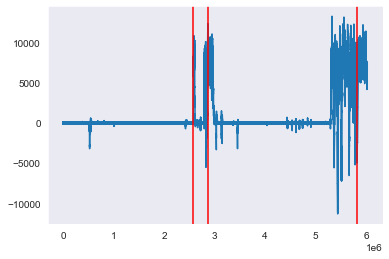

In [323]:
plt.plot(ball[2]-16800)
for idx in valid_idxs:
    plt.axvline(idx, c='r')


c:\users\bramn\anaconda3\envs\datajoint\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  


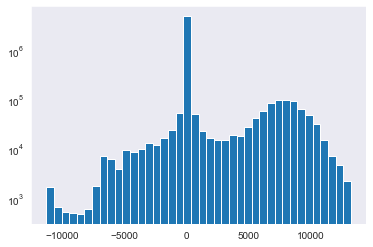

In [324]:
plt.hist(ball[2]-16800, bins=40)
plt.yscale('log', nonposy='clip')


In [325]:
edges = [-10000, -5000, 0, 7500]
# for edge in edges:
#     ball[2] - edge

In [326]:
np.tile(edges, (4, 1)).T

array([[-10000, -10000, -10000, -10000],
       [ -5000,  -5000,  -5000,  -5000],
       [     0,      0,      0,      0],
       [  7500,   7500,   7500,   7500]])

In [327]:
ball[2,:4]-16800

array([-7, 14, 35, 31], dtype=int16)

In [328]:
np.tile(edges, (4, 1)).T - (ball[2,:4]-16800)

array([[ -9993, -10014, -10035, -10031],
       [ -4993,  -5014,  -5035,  -5031],
       [     7,    -14,    -35,    -31],
       [  7507,   7486,   7465,   7469]])

In [329]:
ball_disc = np.argmin(np.abs(np.tile(edges, (len(ball[2]), 1)).T - (ball[2]-16800)), axis=0)

In [330]:
cat1 = (2, 3)
diff_idxs = np.where(np.diff(ball_disc))[0]

In [331]:
len(diff_idxs)

1221

In [332]:
valid_idxs = []
for idx in diff_idxs:
    if np.all(ball_disc[idx-10:idx]==2) and np.all(ball_disc[idx+1:idx+10]==3):
        valid_idxs.append(idx)
print(len(valid_idxs))

3


## Align ephys data with behavior data


In [16]:
from Neuron.datatypes.block import Block

In [17]:
# import Neuron.stages as stages
from Neuron.stages import stage
from Neuron.stages.pipeline import Pipeline
from Neuron.stages.firing_rate_estimation import FiringRateEstimation
from Neuron.stages.downsampling import Downsampling
from Neuron.stages.PCA import PCA
from Neuron.stages.standardization import Standardization
from Neuron.stages.smoothing import Smoothing

In [18]:
unit_info, units = (subsess_spikes_table & {'experiment_id': '01231', 'session_id': '20200327a', 'subsession_id': 'EXPA_0002'}).fetch1('cluster_info', 'clusters')


In [19]:
sorted_table

experiment_id,mouse_id,session_id,spike_times,spike_clusters,cluster_info,spike_templates,amplitudes,channel_positions,channel_map
01230,M01,20200326a,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
01231,M01,20200327a,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
01232,M01,20200328a,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
01233,M01,20200329a,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
01247,M01,20200328e,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
01254,M01,20200303a,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
01261,M01,20200327f,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
01437,M01,20201213a,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
01437,M01,20201214a,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
01437,M01,20201215a,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=


In [37]:
# experiment_ids, session_ids, subsess_ids = (subsess_events_table *sorted_table & {'experiment_id': '01233', 'subsession_id': 'EXPA_0002'}).fetch('experiment_id', 'session_id', 'subsession_id')
# experiment_ids, session_ids, subsess_ids = (subsess_events_table *sorted_table & {'subsession_id': 'EXD_1_0001'}).fetch('experiment_id', 'session_id', 'subsession_id')
# experiment_ids, session_ids, subsess_ids = (subsess_events_table *sorted_table & {'experiment_id': '01233', 'subsession_id': 'CHPE_0009'}).fetch('experiment_id', 'session_id', 'subsession_id')
experiment_ids, session_ids, subsess_ids = (subsess_events_table *sorted_table & {'experiment_id': '01233'}).fetch('experiment_id', 'session_id', 'subsession_id')
# experiment_ids, session_ids, subsess_ids = (subsess_events_table *sorted_table).fetch('experiment_id', 'session_id', 'subsession_id')

# sessions = [{'experiment_id': '01231', 'session_id': '20200327a'}, {'experiment_id': '01232', 'session_id': '20200328a'}, {'experiment_id': '01261', 'session_id': '20200327f'}]
# sessions_sSC_depths = [(1800, 2250), (2000, 2450), (2150, 2550)]

In [38]:
session_ids, experiment_ids

(array(['20200329a', '20200329a', '20200329a', '20200329a', '20200329a',
        '20200329a', '20200329a'], dtype=object),
 array(['01233', '01233', '01233', '01233', '01233', '01233', '01233'],
       dtype=object))

In [39]:
def get_subsession_data(subsess_key):
    """ Retrieves a list of stimtype, neural activity, behavior tuples with all presentations in the subsession. """    
    subsess_block = get_neural(subsess_key=subsess_key, hz=40)
    subsess_pres_blocks = split_presentations(subsess_key, subsess_block, before=int(1000*0.5), after=1000*2)
    behavior, behavior_pres = get_behavior(subsess_key=subsess_key, data_type='raw', hz=40, before=int(20000*0.5), after=20000*2)
    return subsess_block, subsess_pres_blocks, behavior, behavior_pres

subsess_keys = []
trials_neural = []
trials_pres_neural = []
trials_behavior = []
trials_pres_behavior = []
for exp, sess, subsess in zip(experiment_ids, session_ids, subsess_ids):
    print({'experiment_id': exp, 'session_id': sess, 'subsession_id': subsess})
    subsess_key = {'experiment_id': exp, 'session_id': sess, 'subsession_id': subsess}
    subsess_keys.append(subsess_key)
    trial_neural, trial_pres_neural, behavior, behavior_pres = get_subsession_data(subsess_key)
    print("Behavior lenght:", len(behavior[0]))
    trials_neural.append(trial_neural.time_slice(1000, 1000+1000*len(behavior[0])/40))
    trials_pres_neural.append(trial_pres_neural)
    trials_behavior.append(behavior)
    trials_pres_behavior.append(behavior_pres)

{'experiment_id': '01233', 'session_id': '20200329a', 'subsession_id': 'CHPE_0009'}
4
Starts, ends [ 102981  404309  685634 1006629 1247964 1489623 1850284 2031952 2333281
 2614609 2935600 3176934 3418597 3779253 3960921 4262250 4543579 4864569
 5105904 5347566 5708223 5889891 6191220], [ 363640  604973  846636 1207294 1388962 1690290 1971619 2292610 2533943
 2775607 3136263 3317931 3619260 3900589 4221582 4462914 4704576 5065233
 5246901 5548230 5829558 6150549]
Responses shape (22, 50000) [(50000,), (50000,), (50000,), (50000,), (50000,), (50000,), (50000,), (50000,), (50000,), (50000,), (50000,), (50000,), (50000,), (50000,), (50000,), (50000,), (50000,), (50000,), (50000,), (50000,), (50000,), (50000,)]
(22, 50000)
100
(22, 100, 1)
Behavior lenght: 13000
{'experiment_id': '01233', 'session_id': '20200329a', 'subsession_id': 'DIMM_0004'}
4
Starts, ends [ 22618  99616 176615 253615 330613 407612 484611 561610 638608 715607], [ 39285 116284 193282 270280 347280 424278 501278 578276 65

In [73]:
edges = [-3000, 0, 7500]

def filter_behavior_condition(behav, cond):
    # Returns idx of condition
    from scipy.signal import savgol_filter
    behav = savgol_filter(behav, 101, 3, axis=0) # window size 101, polynomial order 3

    behav_disc = np.argmin(np.abs(np.tile(edges, (len(behav), 1)).T - behav), axis=0)
    diff_idxs = np.where(np.diff(behav_disc))[0]
    valid_idxs = []
#     plt.plot(np.squeeze(behav))
    for idx in diff_idxs:
        if np.all(behav_disc[idx-80:idx]==cond[0]) and np.all(behav_disc[idx+1:idx+80]==cond[1]):
            valid_idxs.append(idx)
#             plt.axvline(idx, c='r')
#     plt.show()
#     print(len(valid_idxs))
    
    return valid_idxs

def get_cond_behavior(trials_behavior, cond, before=100, after=100):
    running_behav = []
    idxs = []
    for behav in trials_behavior:
        behav = np.squeeze(behav)

        running_idxs = filter_behavior_condition(behav, cond)
        idxs.append(running_idxs)
        for idx in running_idxs:
#             print(idx)
            if len(behav[idx-before:idx+after]) == before+after:
                running_behav.append(behav[idx-before:idx+after])
    return running_behav, idxs

def get_cond_neural(trials_behavior, idxs, cond, depth_slice=None, before=100, after=100):
    running_neural = []
    for neur, running_idxs in zip(trials_neural, idxs):
        for idx in running_idxs:
            if depth_slice is None:
                n = neur.get_view('counts')
            else:
#                 print("Depth slice", depth_slice)
                n = neur.depth_slice(min_depth=depth_slice[0], max_depth=depth_slice[1]).get_view('counts')
#                 print(n.shape)
#                 n_sub = n[:,idx-before:idx+after]
#                 print(idx)
#                 print("Neur", neur.get_view('counts').shape)

#             print(n.shape)
            if n.shape[0] != 0:
                n_sub = n[:,idx-before:idx+after]
                if n_sub.shape[1] == before+after:
                    running_neural.append(n_sub)
    return running_neural


In [74]:
# plt.plot(np.stack(running_behav).T)
# df = pd.DataFrame(np.stack(running_behav)).melt()
# sb.lineplot(x="variable", y="value", data=df, estimator='mean', ci='sd')


7
6


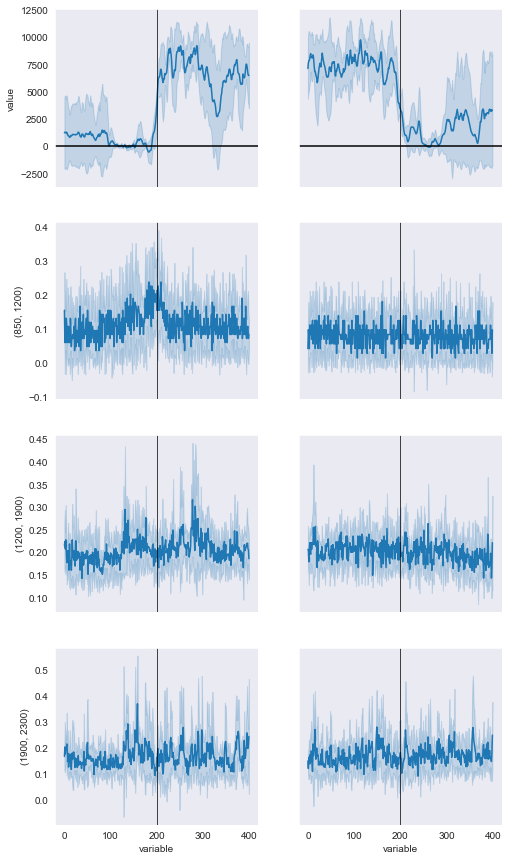

In [57]:
conditions = [(1, 2), (2, 1)] # (1,0), (0,1)
# depth_slices = [(d, d+300) for d in np.arange(2100, -200, -300)]
depth_slices = [(850, 1200), (1200, 1900), (1900, 2300)]

fig, axs = plt.subplots(len(depth_slices)+1, len(conditions), sharey='row', sharex=True, figsize=(8, 15))
for i, condition in enumerate(conditions):
    behav, idxs = get_cond_behavior(trials_behavior, condition, before=200, after=200)
    print(len(behav))
#     print(idxs)
    if len(behav) != 0:
        df = pd.DataFrame(np.stack(behav)).melt()
        sb.lineplot(x="variable", y="value", data=df, estimator='mean', ci='sd', ax=axs[0,i])
        axs[0, i].axvline(200, c='k', linewidth=0.8, alpha=0.9)
        axs[0, i].axhline(0, c='k')

        for j, depth_slice in enumerate(depth_slices):
            neur = get_cond_neural(trials_neural, idxs, condition, depth_slice=depth_slice, before=200, after=200)
    #         print(neur)
            mean_counts = []
            for n in neur:
    #             print(n)
                mean_counts.append(np.mean(n, axis=0))
            if len(mean_counts) != 0:
                df = pd.DataFrame(np.stack(mean_counts)).melt()
                sb.lineplot(x="variable", y="value", data=df, estimator='mean', ci='sd', ax=axs[j+1,i])
                axs[j+1,i].set(ylabel=depth_slice)
                axs[j+1, i].axvline(200, c='k', linewidth=0.8, alpha=0.9)

plt.show()

# Get instantaneous firing rates!
# Get correlations!

7
9


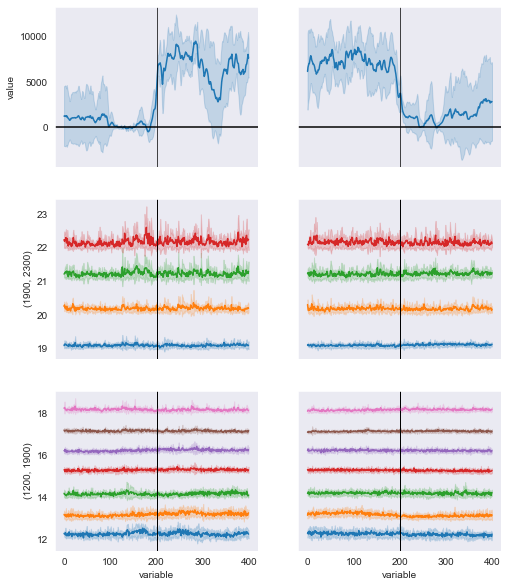

In [75]:
conditions = [(1, 2), (2, 1)] # (1,0), (0,1)
# depth_slices = [(d, d+300) for d in np.arange(2100, -200, -300)]
depth_slices = [(1900, 2300), (1200, 1900)]

fig, axs = plt.subplots(len(depth_slices)+1, len(conditions), sharey='row', sharex=True, figsize=(8, 10))
for i, condition in enumerate(conditions):
    behav, idxs = get_cond_behavior(trials_behavior, condition, before=200, after=200)
    print(len(behav))
#     print(idxs)
    if len(behav) != 0:
        df = pd.DataFrame(np.stack(behav)).melt()
        sb.lineplot(x="variable", y="value", data=df, estimator='mean', ci='sd', ax=axs[0,i])
        axs[0, i].axvline(200, c='k', linewidth=0.8, alpha=0.9)
        axs[0, i].axhline(0, c='k')

        for j, depth_slice in enumerate(depth_slices):
            low, high = depth_slice
            for z in np.arange(low, high, 100):
#                 print(z, z+50)
                neur = get_cond_neural(trials_neural, idxs, condition, depth_slice=(z,z+100), before=200, after=200)
                mean_counts = []
                for n in neur:
                    mean_counts.append(np.mean(n, axis=0))
#                 print(len(mean_counts))
                if len(mean_counts) != 0:
#                     np.mean(mean_counts)
                    df = pd.DataFrame(np.stack(mean_counts)+z/100).melt()
                    sb.lineplot(x="variable", y="value", data=df, estimator='mean', ci='sd', ax=axs[j+1,i])
                    axs[j+1,i].set(ylabel=depth_slice)
                    axs[j+1, i].axvline(200, c='k', linewidth=0.8, alpha=0.9)
# Take mean and sd across neurons and trials? 
plt.show()


In [ ]:
# Get correlations!
from scipy import signal

conditions = [(1, 2), (2, 1)] # (1,0), (0,1)
# depth_slices = [(d, d+300) for d in np.arange(2100, -200, -300)]
depth_slices = [(1900, 2300), (1200, 1900)]

fig, axs = plt.subplots(len(depth_slices)+1, len(conditions), sharey='row', sharex=True, figsize=(8, 10))
for i, condition in enumerate(conditions):
    behav, idxs = get_cond_behavior(trials_behavior, condition, before=200, after=200)
    print(len(behav))
    if len(behav) != 0:
        df = pd.DataFrame(np.stack(behav)).melt()
        sb.lineplot(x="variable", y="value", data=df, estimator='mean', ci='sd', ax=axs[0,i])
        axs[0, i].axvline(200, c='k', linewidth=0.8, alpha=0.9)
        axs[0, i].axhline(0, c='k')

        for j, depth_slice in enumerate(depth_slices):
            low, high = depth_slice
            for z in np.arange(low, high, 100):
#                 print(z, z+50)
                neur = get_cond_neural(trials_neural, idxs, condition, depth_slice=(z,z+100), before=200, after=200)
                # Calc correlation between behavior and neural activity
                for b, n in zip(behav, neur):
                    corr = signal.correlate(b, n)
            
                mean_counts = []
                for n in neur:
                    mean_counts.append(np.mean(n, axis=0))
#                 print(len(mean_counts))
                if len(mean_counts) != 0:
#                     np.mean(mean_counts)
                    df = pd.DataFrame(np.stack(mean_counts)+z/100).melt()
                    sb.lineplot(x="variable", y="value", data=df, estimator='mean', ci='sd', ax=axs[j+1,i])
                    axs[j+1,i].set(ylabel=depth_slice)
                    axs[j+1, i].axvline(200, c='k', linewidth=0.8, alpha=0.9)

In [96]:
""" Add instantaneous firing rate to blocks """
hz = 40
for trial in trials_neural:
    line = Pipeline()
    line.add_stage(FiringRateEstimation(fr_type='instantaneous'), binsize=30*(1000/hz), sampling_period=1000/hz) # 30*25 ==> hz=40
    #     line.add_stage(Downsampling(ds_type='standard'), sz=40)
    line.add_stage(Smoothing(smoothing_type='gaussian'), sigma=2)
    firing_rates = line.execute(trial.get_view('spikes'), meta=None)[-1]
    trial.add_view('instantaneous', firing_rates, hz=hz) # time axis...


(263, 13277)
(263, 13277)
(263, 2080)
(263, 2080)
(263, 2079)
(263, 2079)
(263, 2473)
(263, 2473)
(263, 2508)
(263, 2508)
(263, 2076)
(263, 2076)
(263, 2077)
(263, 2077)


In [97]:
""" Concatenate blocks & calculate PCA """
all_trials_npy = []
for trial in trials_neural:
    all_trials_npy.append(trial.depth_slice(min_depth=1900, max_depth=2300).get_view('instantaneous'))
all_trials_npy = np.concatenate(all_trials_npy, axis=1)

In [98]:
all_trials_npy.shape

(74, 26570)

In [99]:
np.any(all_trials_npy!=0)

True

In [100]:
np.all(all_trials_npy==0, axis=1)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

Received inp: (74, 26570)
Received inp: (26570, 74)


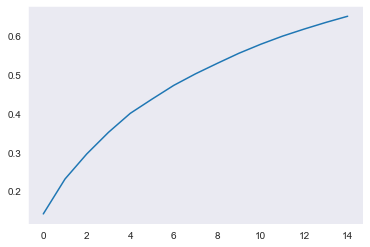

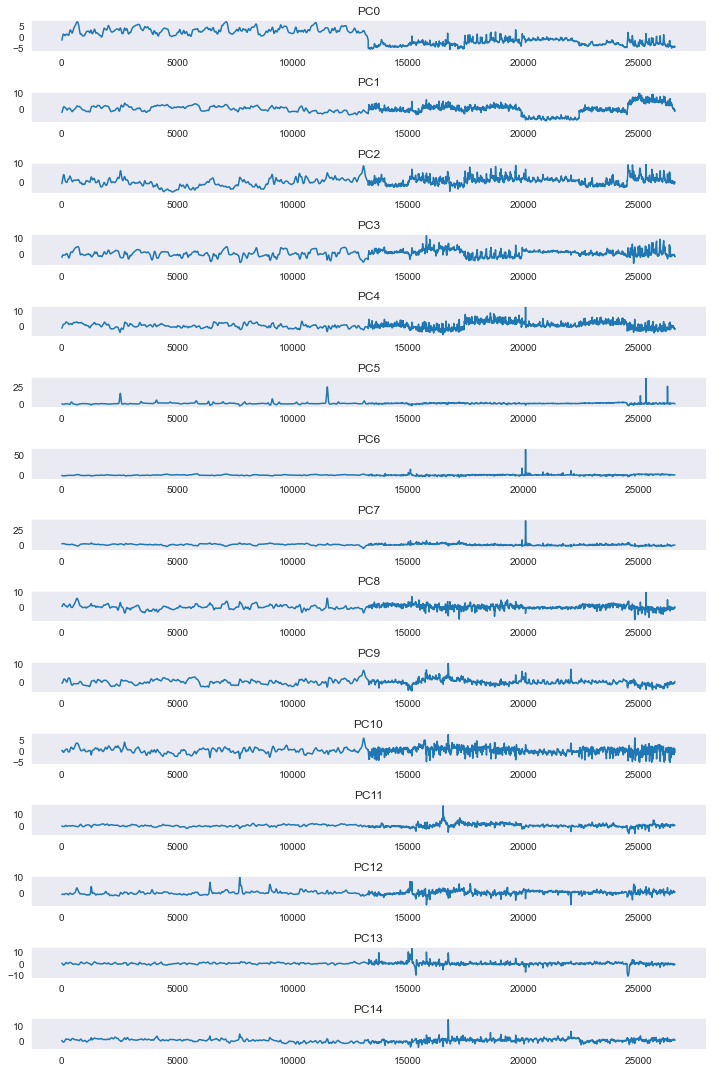

In [101]:
pca_stage = PCA(n_components=15, transpose=False, visualize=True)
stand = Standardization(transpose=True)
line = Pipeline()
line.add_stage(stand)
line.add_stage(pca_stage) # 30*25 ==> hz=40
#     line.add_stage(Downsampling(ds_type='standard'), sz=40)
X_pca = line.execute(all_trials_npy, meta=None)[-1]  

In [131]:
X_pca.shape

(26570, 15)

In [133]:
pca_stage.pca.n_features_

74

In [134]:
pca_stage.pca.n_components

15

In [136]:
pca_stage.pca.components_.shape

(15, 74)

In [102]:
pca_stage.pca

PCA(copy=True, iterated_power='auto', n_components=15, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [103]:
neural = trials_pres_neural[2]

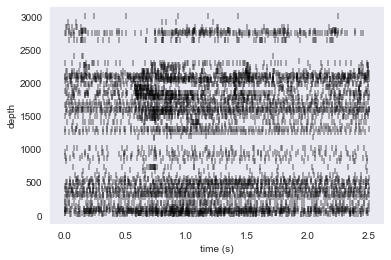

In [104]:
from Neuron.visualization import spikes
fig, axs = plt.subplots(1, 1)
spikes.plot_raster(trials_pres_neural[2][0], ax=axs, visualize_depth=True)

In [127]:
trials_pres_neural[2][0].get_view('spikes').shape

(263,)

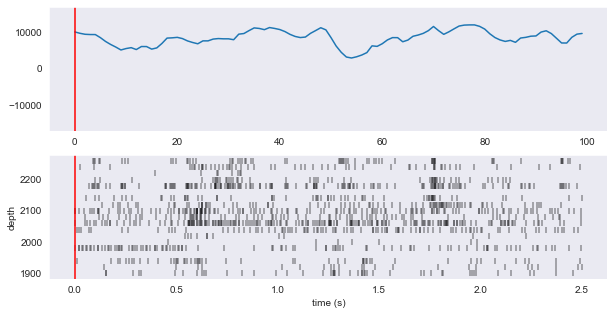

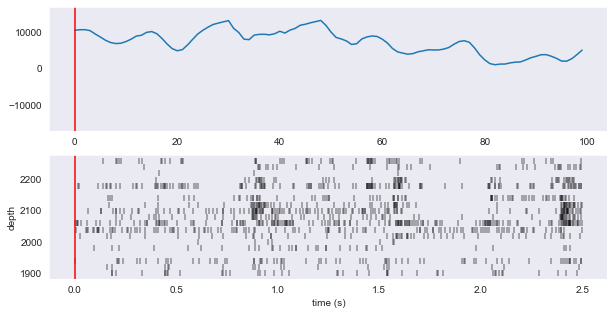

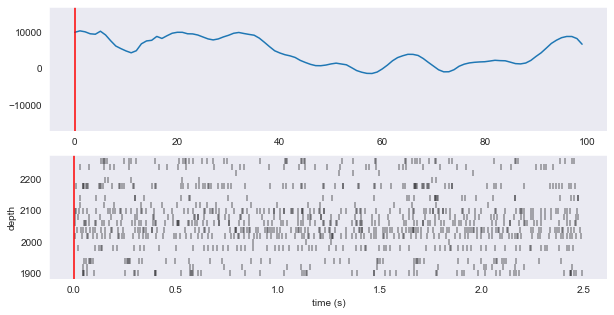

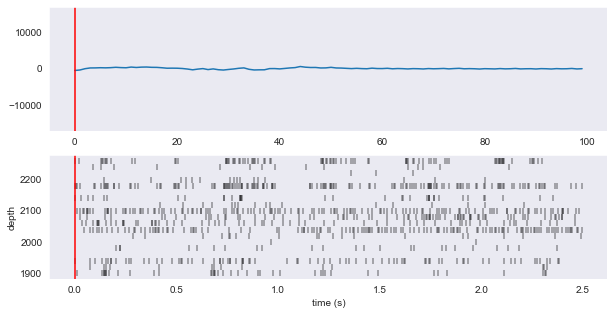

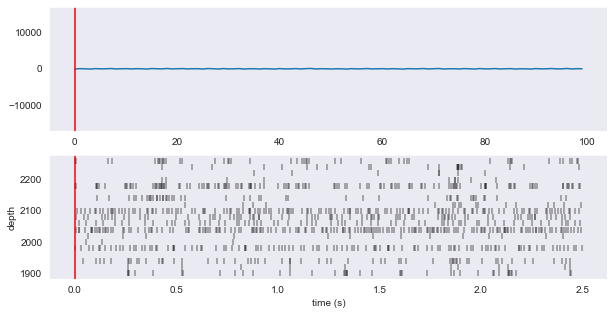

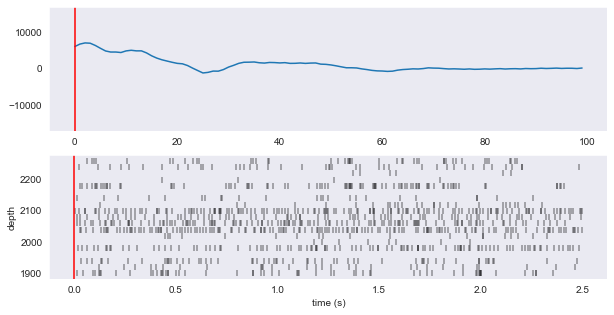

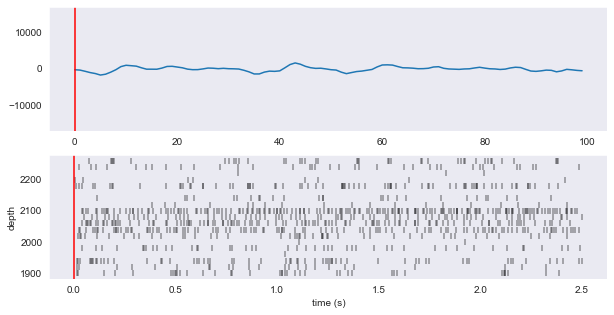

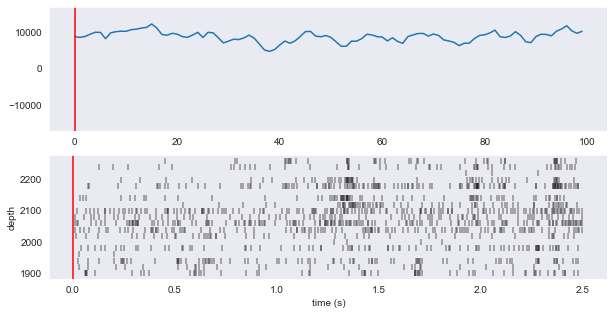

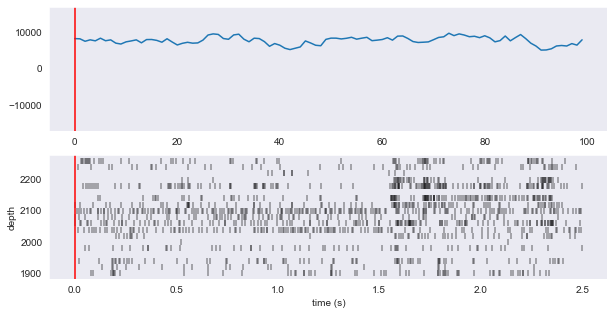

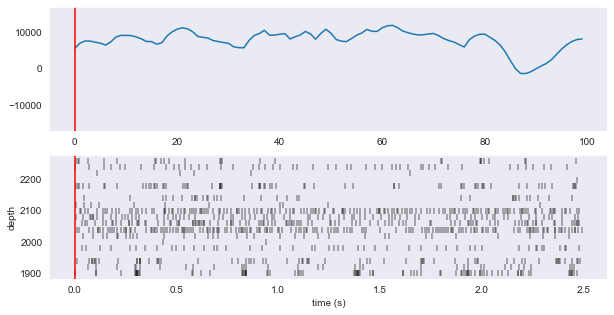

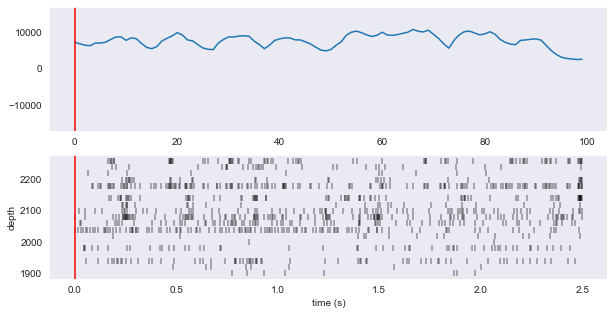

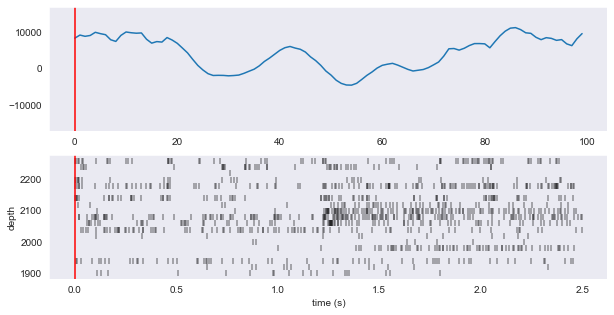

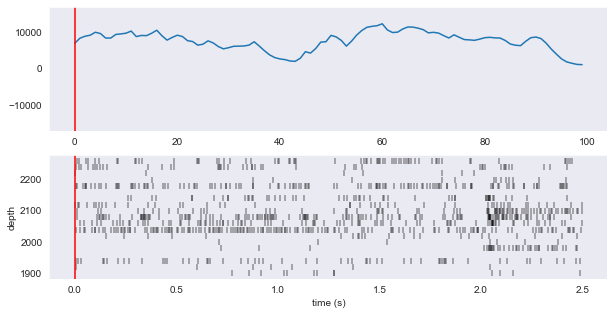

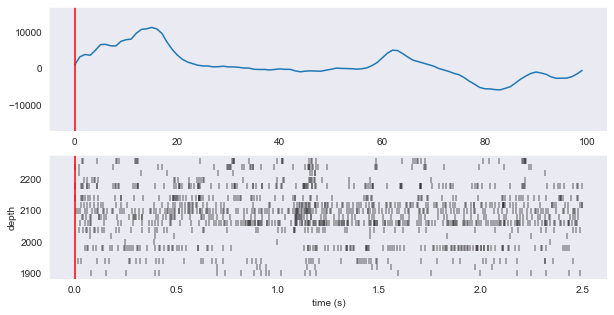

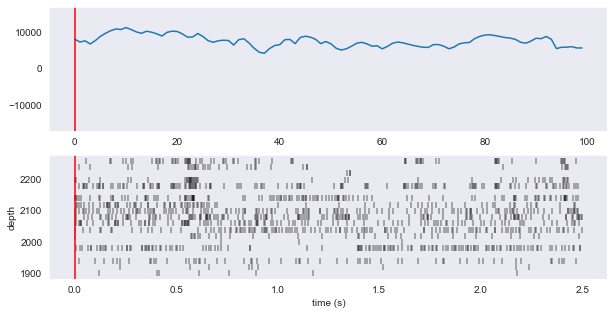

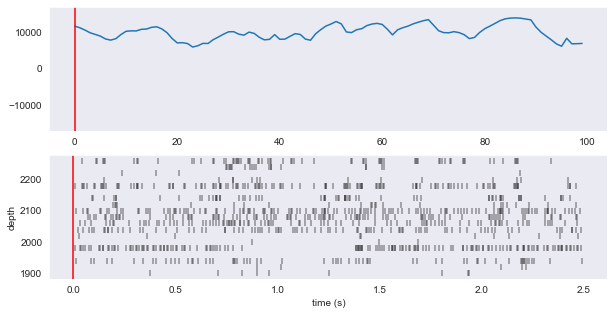

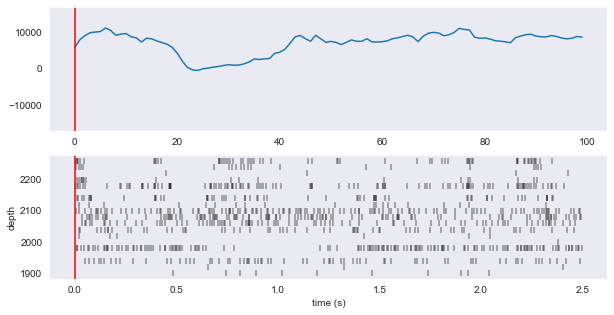

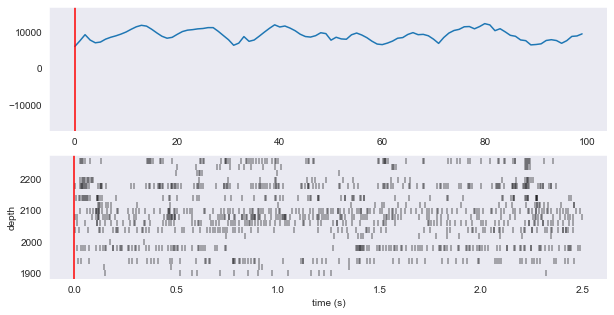

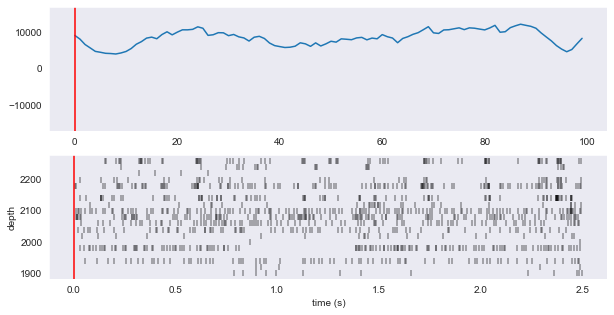

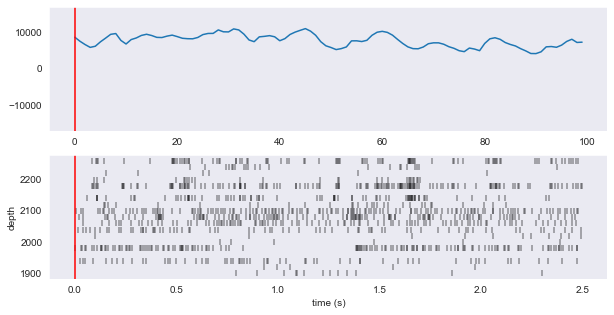

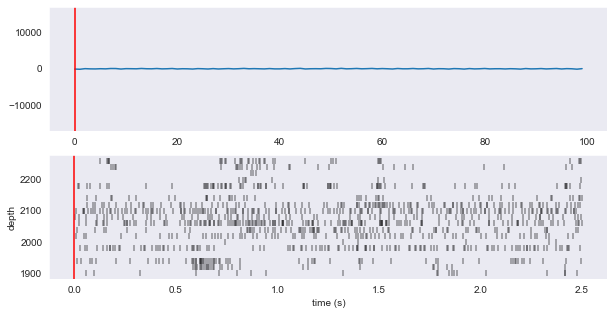

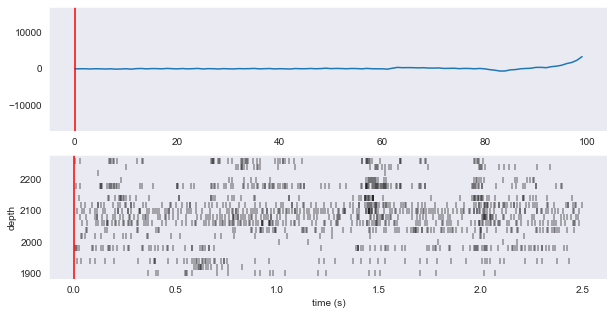

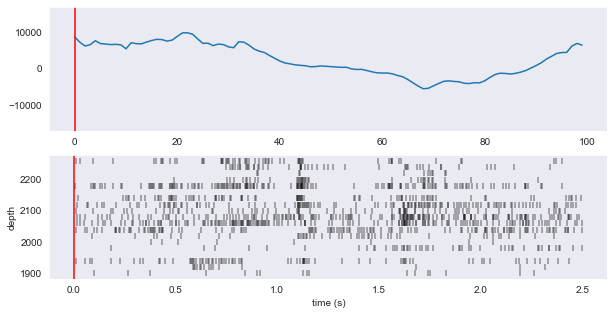

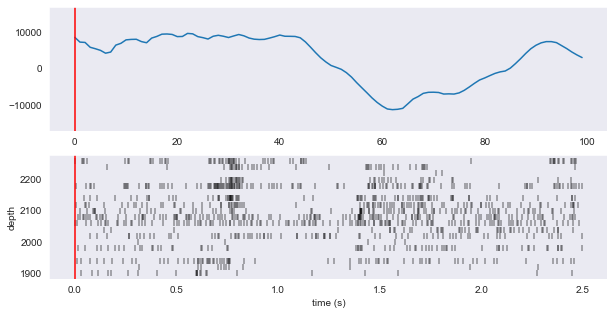

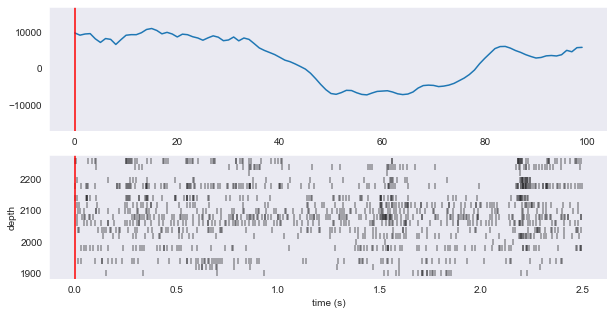

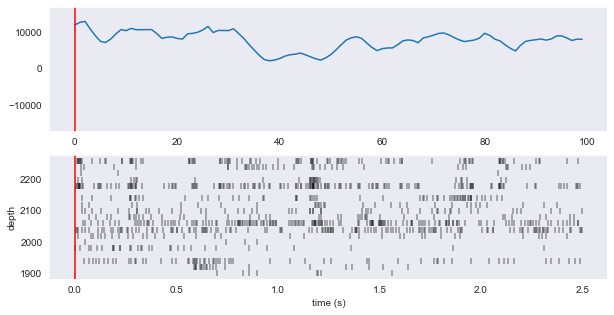

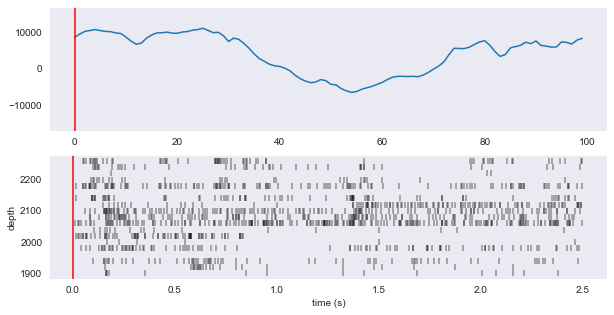

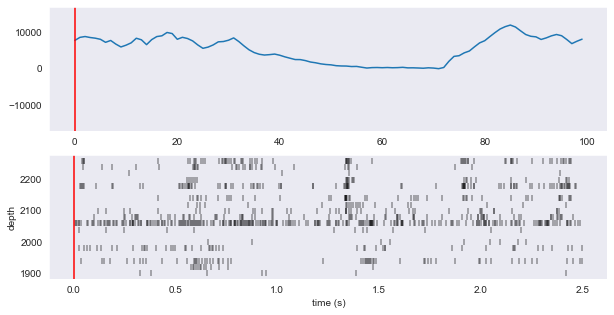

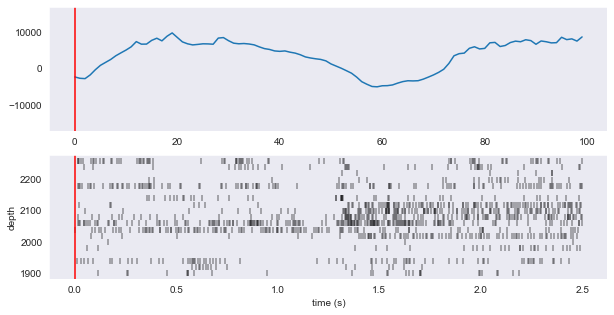

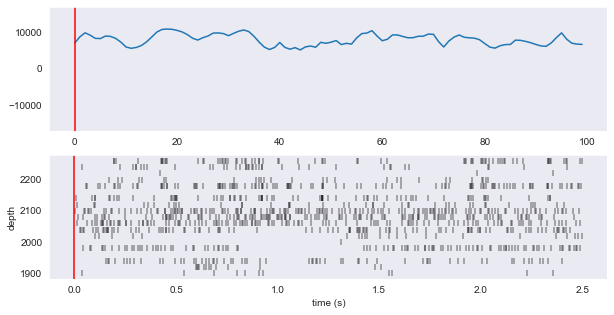

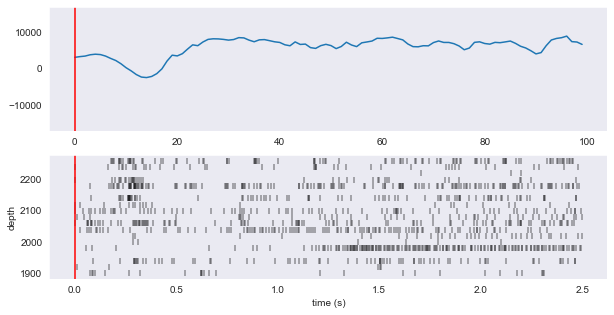

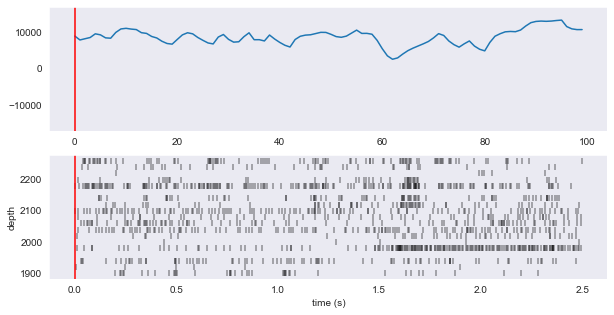

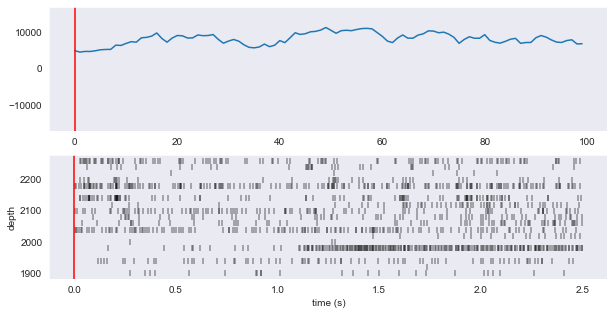

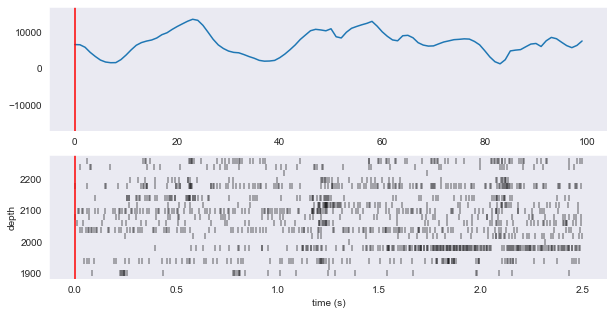

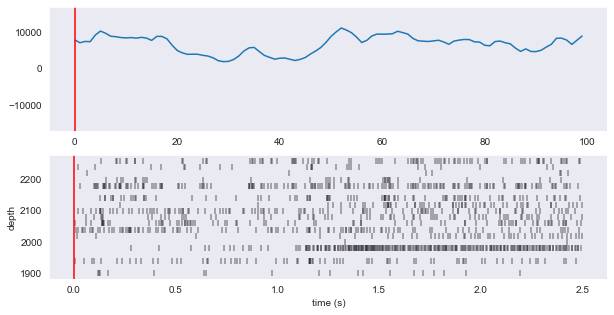

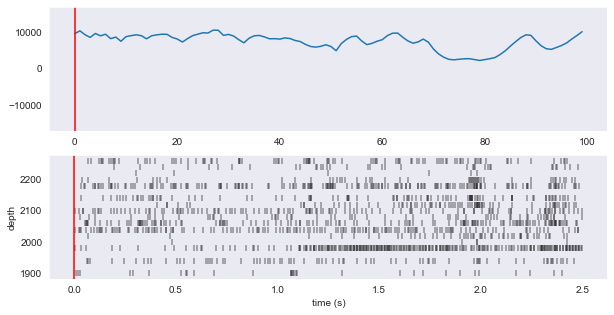

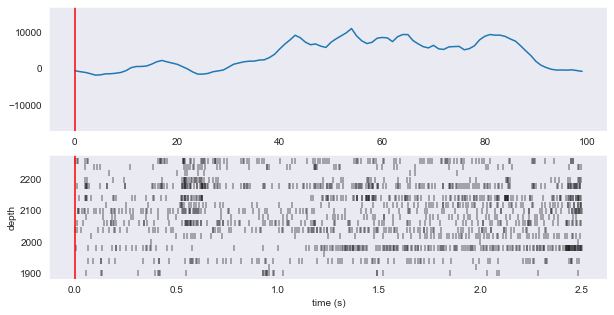

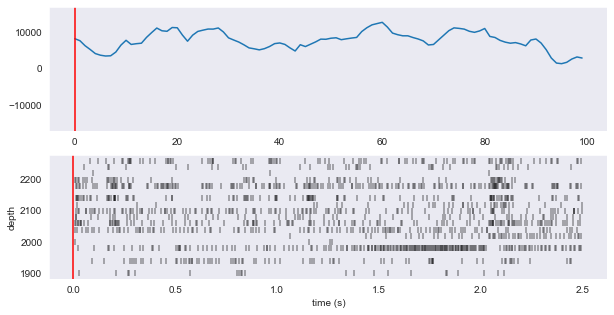

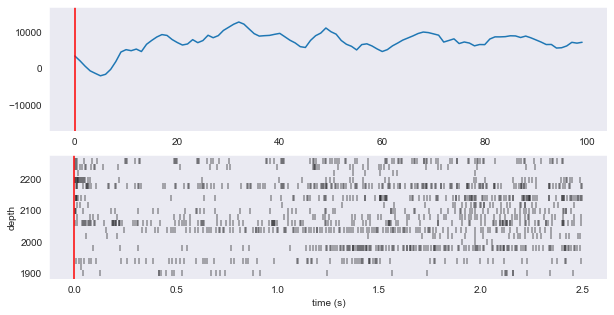

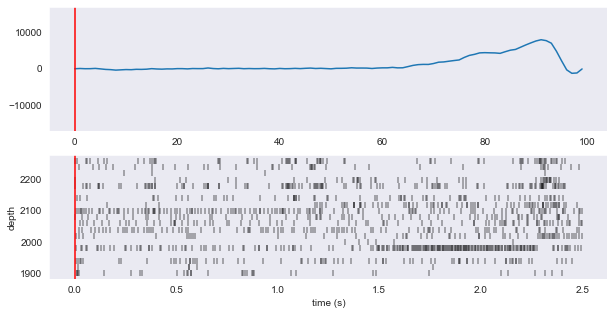

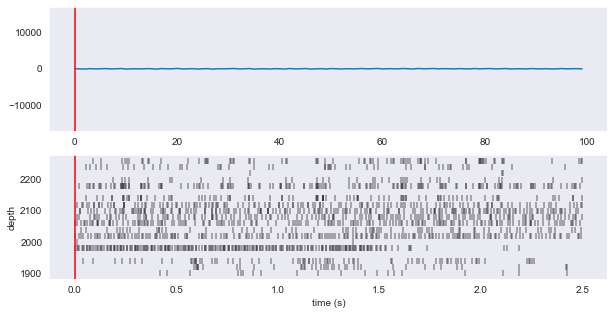

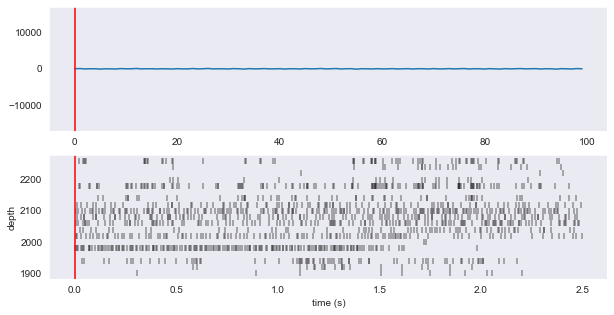

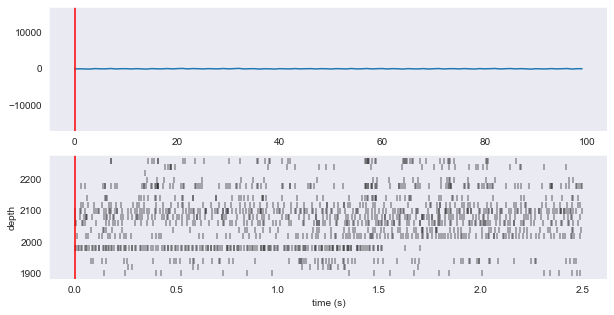

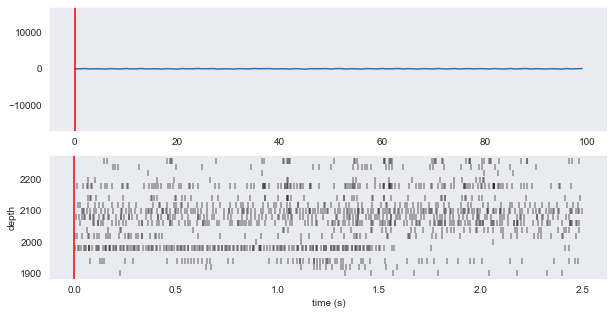

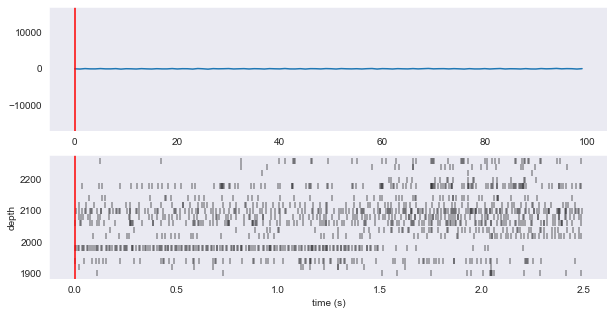

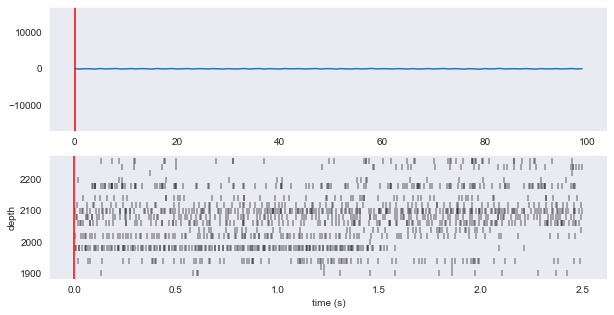

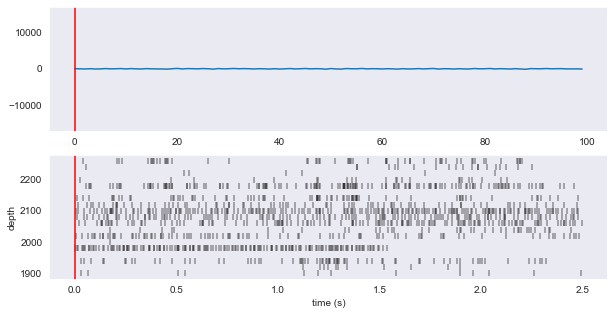

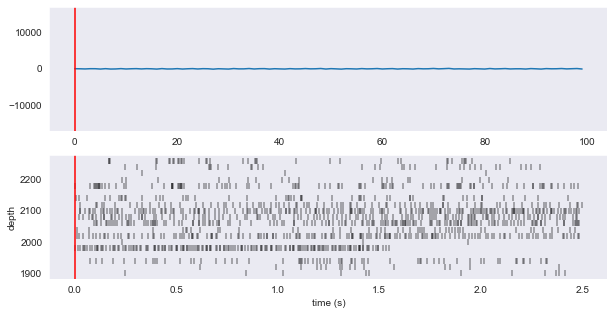

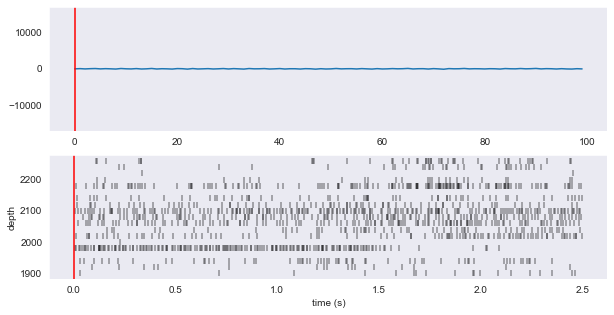

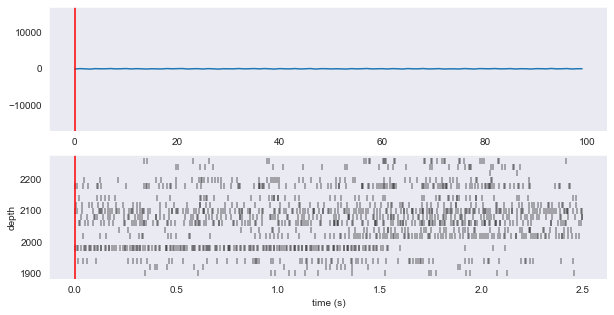

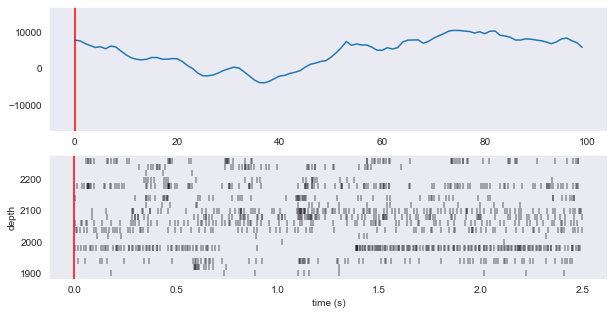

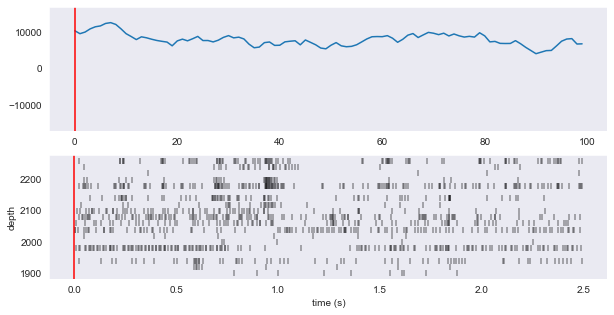

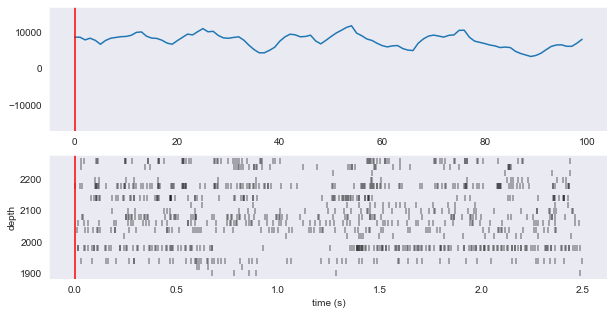

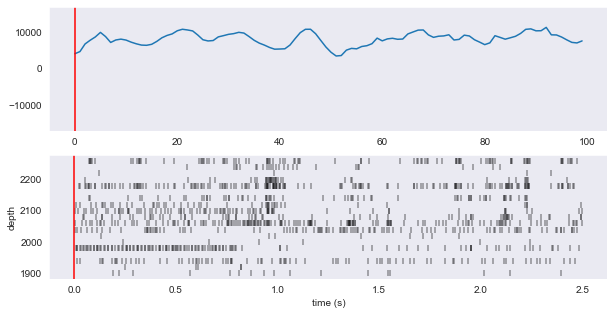

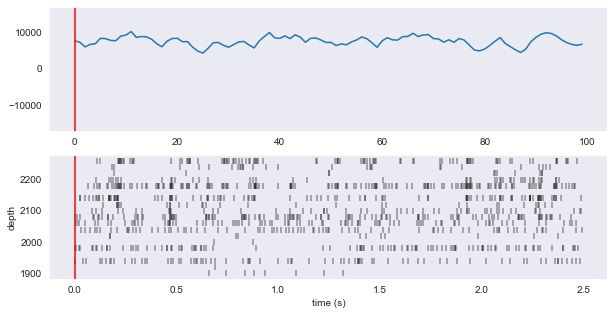

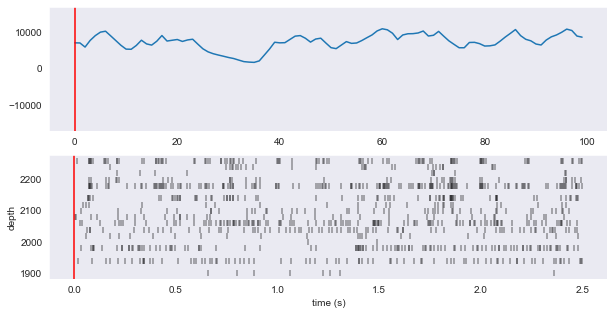

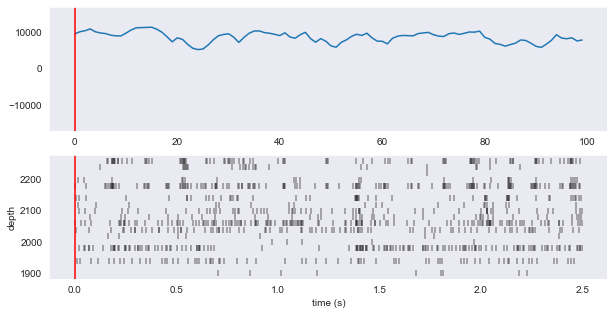

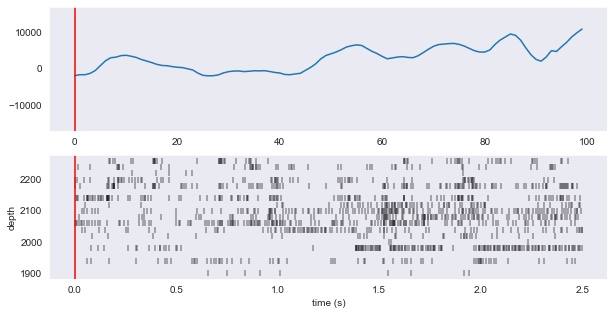

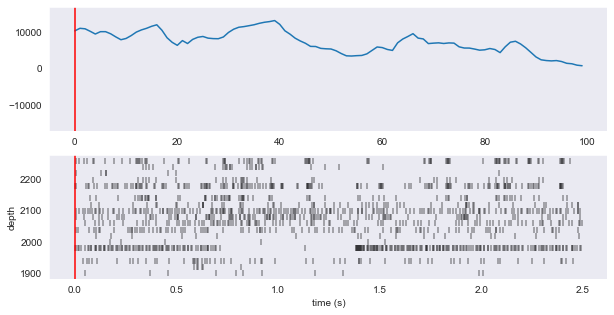

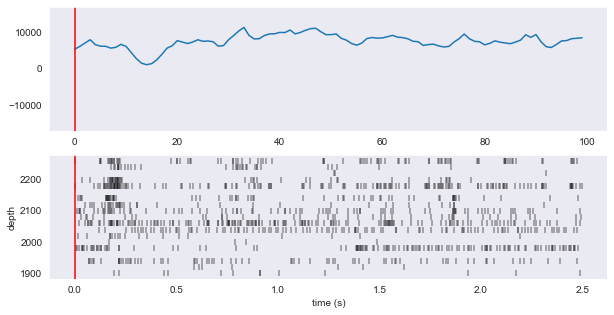

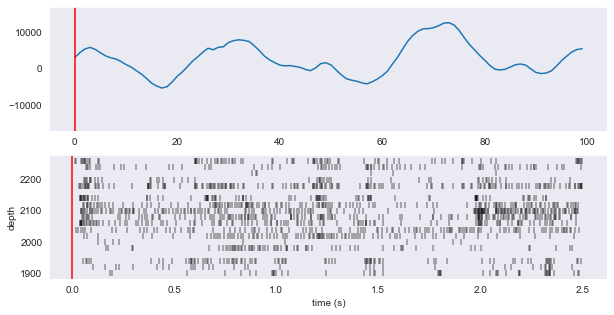

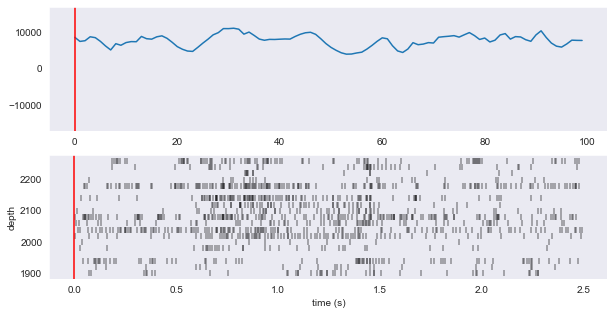

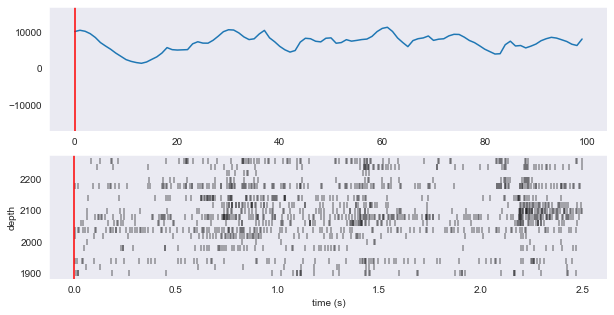

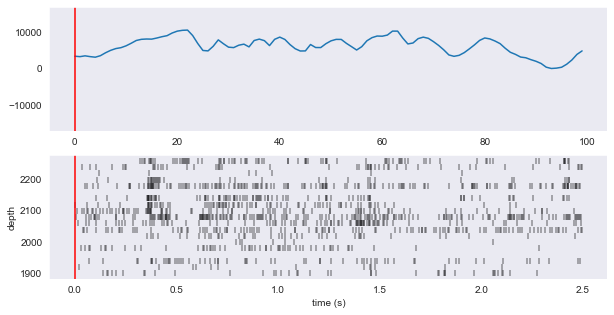

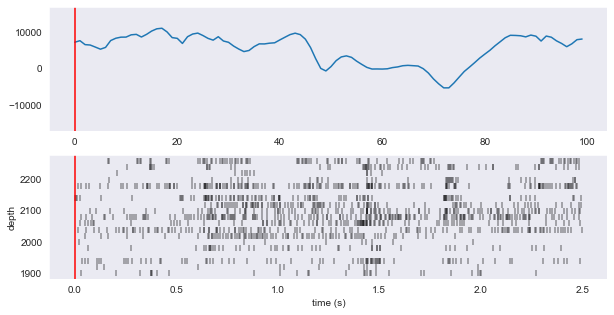

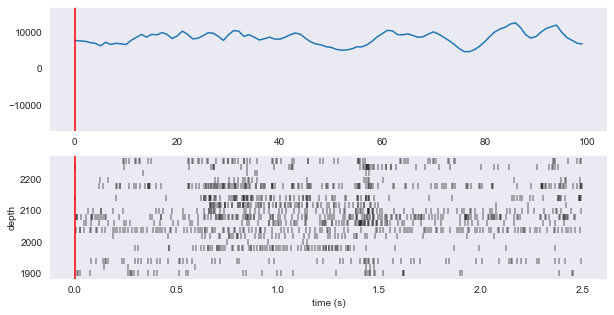

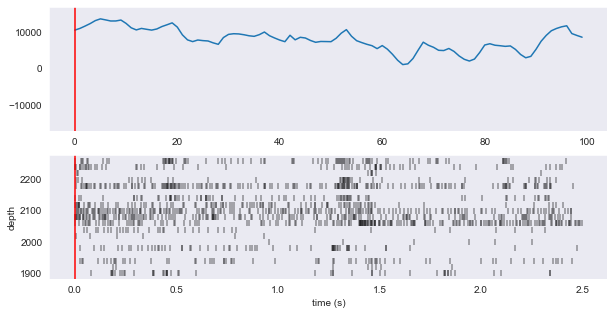

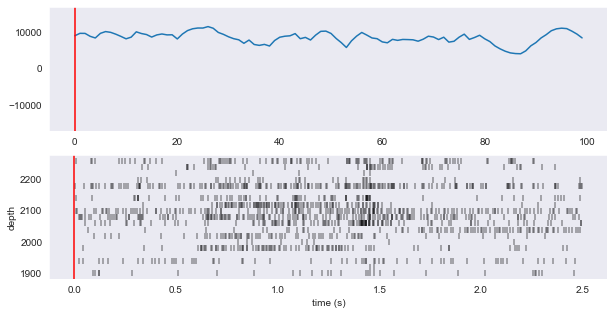

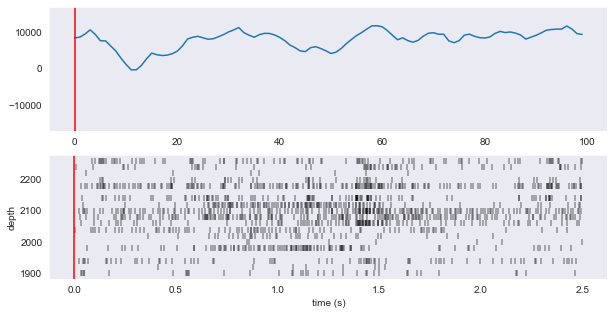

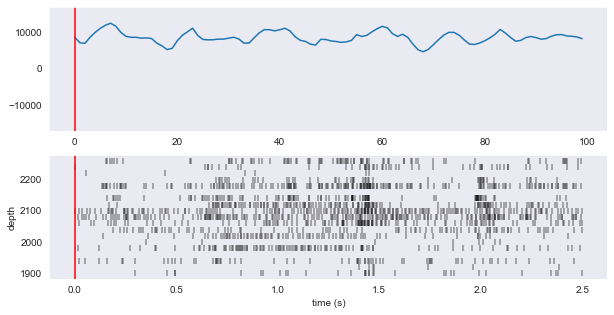

In [105]:
trials_pres_neural

for behav, neur in zip(trials_pres_behavior, trials_pres_neural):
    for behav_trial, neur_trial in zip(behav, neur):
        fig, axs = plt.subplots(2, 1, figsize=(10, 5))
        axs[0].plot(behav_trial)
        axs[0].set(ylim=[-16800, 16800])
        spikes.plot_raster(neur_trial.depth_slice(min_depth=1900, max_depth=2300), ax=axs[1], visualize_depth=True)
#         axs[1].plot(neur_trial.depth_slice(min_depth=1900, max_depth=2300).get_view('counts').mean(axis=0))
        axs[0].axvline(0, c='r')
        axs[1].axvline(0, c='r')
        plt.show()


In [106]:
len(behavior)

10

In [107]:
trials_pres_neural[2]

(74, 99)
(74, 99)
Received inp: (74, 99)
Received inp: (99, 74)
pcs shape (99, 15)
behav shape (100, 1)


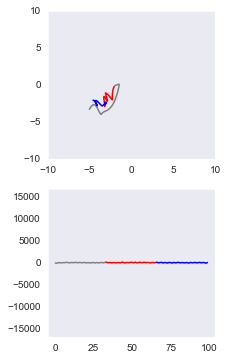

(74, 99)
(74, 99)
Received inp: (74, 99)
Received inp: (99, 74)
pcs shape (99, 15)
behav shape (100, 1)


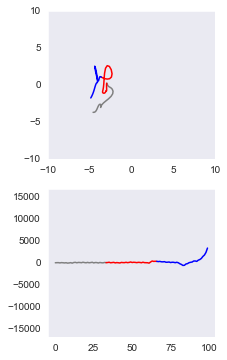

(74, 99)
(74, 99)
Received inp: (74, 99)
Received inp: (99, 74)
pcs shape (99, 15)
behav shape (100, 1)


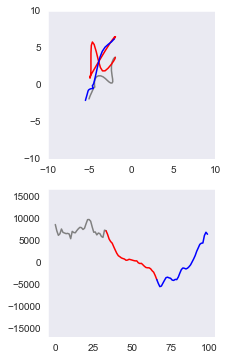

(74, 99)
(74, 99)
Received inp: (74, 99)
Received inp: (99, 74)
pcs shape (99, 15)
behav shape (100, 1)


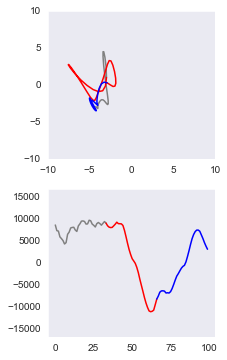

(74, 99)
(74, 99)
Received inp: (74, 99)
Received inp: (99, 74)
pcs shape (99, 15)
behav shape (100, 1)


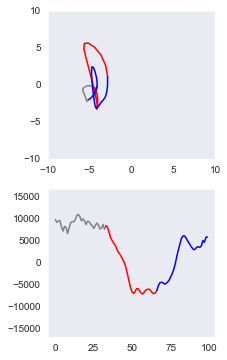

(74, 99)
(74, 99)
Received inp: (74, 99)
Received inp: (99, 74)
pcs shape (99, 15)
behav shape (100, 1)


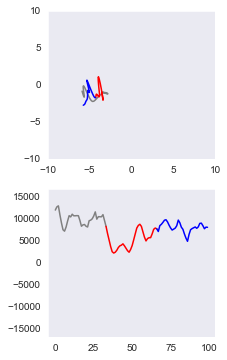

(74, 99)
(74, 99)
Received inp: (74, 99)
Received inp: (99, 74)
pcs shape (99, 15)
behav shape (100, 1)


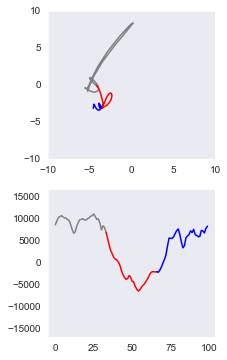

(74, 99)
(74, 99)
Received inp: (74, 99)
Received inp: (99, 74)
pcs shape (99, 15)
behav shape (100, 1)


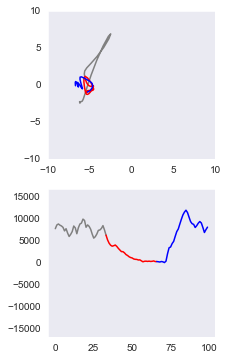

(74, 99)
(74, 99)
Received inp: (74, 99)
Received inp: (99, 74)
pcs shape (99, 15)
behav shape (100, 1)


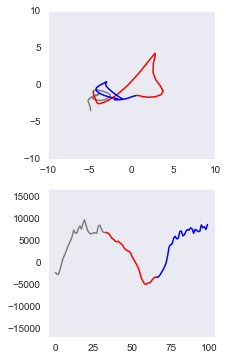

(74, 99)
(74, 99)
Received inp: (74, 99)
Received inp: (99, 74)
pcs shape (99, 15)
behav shape (100, 1)


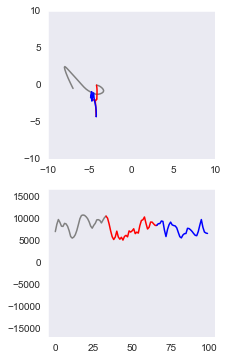

In [144]:
vis_stim = 2
hz=40
trials_pres_pcs = []
for trial_behavior, trial_neural in zip(trials_pres_behavior[vis_stim], trials_pres_neural[vis_stim]):
    block = trial_neural.depth_slice(min_depth=1900, max_depth=2300)
    line = Pipeline()
    line.add_stage(FiringRateEstimation(fr_type='instantaneous'), binsize=30*(1000/hz), sampling_period=1000/hz) # 30*25 ==> hz=40
    #     line.add_stage(Downsampling(ds_type='standard'), sz=40)
    line.add_stage(Smoothing(smoothing_type='gaussian'), sigma=2)

    line.add_stage(Standardization(transpose=True, scaler=stand.get_params()))
    line.add_stage(PCA(n_components=10, pca=pca_stage.get_params(), transpose=False))
    pcs = line.execute(block.get_view('spikes'), meta=None)[-1]
    trials_pres_pcs.append(pcs)
    print('pcs shape', pcs.shape)
    print('behav shape', trial_behavior.shape)
    
    fig, axs = plt.subplots(2, 1, figsize=(3, 6))
    axs[0].plot(pcs[:34,0], pcs[:34,1], c='gray')
    axs[0].plot(pcs[33:67,0], pcs[33:67,1], c='red')
    axs[0].plot(pcs[66:,0], pcs[66:,1], c='blue')
    axs[0].set(xlim=(-10, 10), ylim=(-10, 10))
    axs[1].plot(np.arange(0, 34), trial_behavior[:34], c='gray')
    axs[1].plot(np.arange(33, 67), trial_behavior[33:67], c='red')
    axs[1].plot(np.arange(66, 100), trial_behavior[66:], c='blue')
    axs[1].set(ylim=(-16800, 16800))
    plt.show()
trials_pres_pcs = np.array(trials_pres_pcs)

In [116]:
trials_pres_pcs

(10, 99, 15)

In [109]:
stand.scaler.mean_.shape

(74,)

In [46]:
# block = neural[0][1].depth_slice(min_depth=1000, max_depth=1900)
block = trials_pres_neural[2][0].depth_slice(min_depth=1900, max_depth=2300)

In [47]:
len(block.units)

74

Received inp: (74, 99)


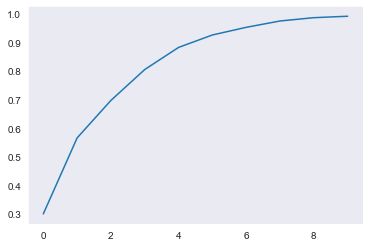

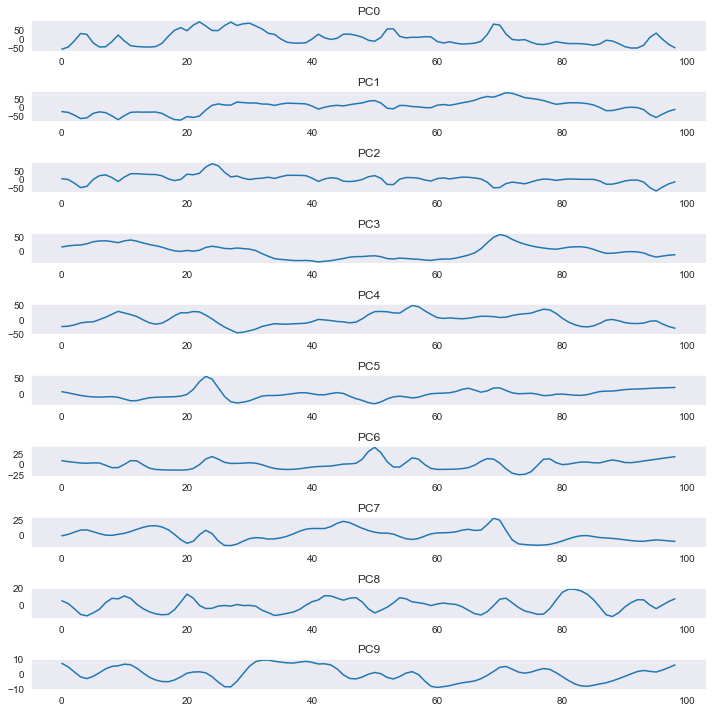

In [99]:
hz=40
line = Pipeline()
line.add_stage(FiringRateEstimation(fr_type='instantaneous'), binsize=30*(1000/hz), sampling_period=1000/hz) # 30*25 ==> hz=40
#     line.add_stage(Downsampling(ds_type='standard'), sz=40)
# D
line.add_stage(PCA(n_components=10, standardize=True, transpose=True, visualize=True))
pcs = line.execute(block.get_view('spikes'), meta=None)[-1]


In [100]:
pcs.shape

(99, 10)

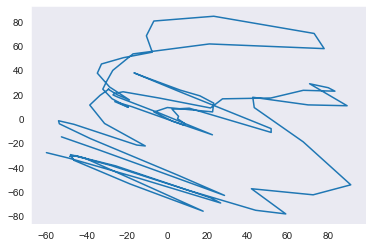

In [103]:
plt.plot(pcs[:,0], pcs[:,1])
plt.show()

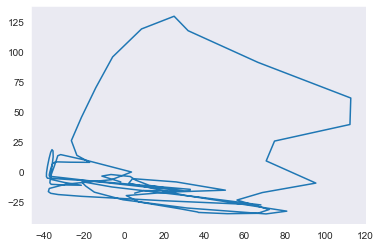

In [89]:
plt.plot(pcs[:,0], pcs[:,1])
plt.show()

(70, 99)
(70, 99)
Received inp: (70, 99)


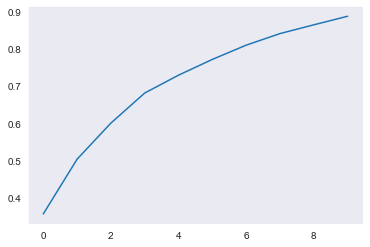

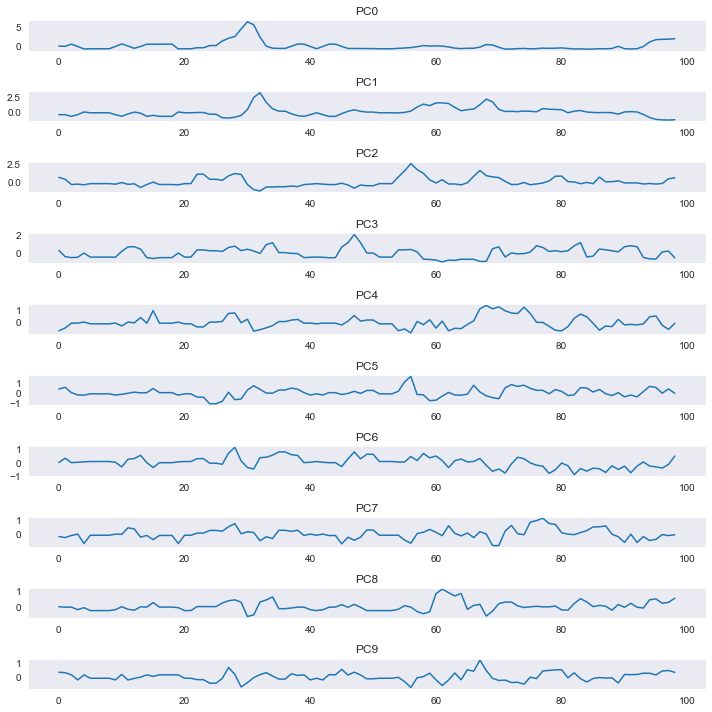

In [82]:
line = Pipeline()
line.add_stage(FiringRateEstimation(fr_type='counts'), binsize=30*(1000/hz), sampling_period=40) # 30*25 ==> hz=40
#     line.add_stage(Downsampling(ds_type='standard'), sz=40)
line.add_stage(Smoothing(smoothing_type='gaussian'), sigma=1)
line.add_stage(PCA(n_components=10, standardize=True, transpose=True, visualize=True))
pcs = line.execute(block.get_view('spikes'), meta=None)[-1]


# Decoding

In [ ]:
def load_session(session_key):
    print(session_key)
    stims_dict = {}
    for stim in stims_vis:
        stims_dict[stim] = {}
        subsess_key = session_key
        subsess_key['subsession_type'] = stim
        fr_tensor, fr_tensor_meta = get_fr_tensor(subsess_key, binsize=30, before=int(30000*0), after=int(30000*0))
        subsess_key = {'subsession_type': stim, 'experiment_id': session_key['experiment_id'], 'session_id': session_key['session_id']}
        stims_dict[stim]['key'] = subsess_key
        stims_dict[stim]['fr_tensor'] = fr_tensor
        stims_dict[stim]['fr_tensor_meta'] = fr_tensor_meta
    return stims_dict

sessions_list = []
for sess in sessions:
    sessions_list.append(load_session(sess))

In [ ]:
subsess_events_table.populate({'experiment_id': '01437'})